# Importación de Librerías

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn  
import keras 
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
import sklearn
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from keras.utils.vis_utils import plot_model


drive.mount('/Drive')
path = '/Drive/MyDrive/data_processed'

Mounted at /Drive


# Menú inicial

PROGRAMA CLASSIFICADOR DE PACIENTS EN ENSAJOS CLÍNICS

In [ ]:
print("\nBenvinguts al programa de detecció de pacients aptes\n\n Començarem amb un qüestionari de característiques que han de reunir els pacients del ensaig:\n")

camp_1 = None
while camp_1 not in [0,1,2]:
  try:
    camp_1 = int(input("  - Home (0) / Dona (1) / Ambdos (2): "))
  except:
    print("Introdueix un enter!")

camp_2 = None
while camp_2 not in range(110):
  try:
    camp_2 = int(input("  - Age_1: "))
  except:
    print("Introdueix un enter!")

camp_3 = None
while camp_3 not in range(110):
  try:
    camp_3 = int(input("  - Age_2: "))
  except:
    print("Introdueix un enter!")

camp_4 = None
while camp_4  not in [0,1]:
  try:
    camp_4 = int(input("  - Cronic disease: "))
  except:
    print("Introdueix un enter!")

camp_5 = None
while camp_5 not in [0,1]:
  try:
    camp_5 = int(input("  - Medication last 15 days: "))
  except:
    print("Introdueix un enter!")

camp_6 = None
while camp_6  not in [0,1]:
  try:
    camp_6 = int(input("  - Smoke: "))
  except:
    print("Introdueix un enter!")

print(f"\nEls filtres escollits han estat els següents: \n  Sexe: {camp_1}, \n  Edat entre {camp_2} i {camp_3}, \n  Medicació 15 últims dies: {camp_4}, \n  Fuma: {camp_5}")


Benvinguts al programa de detecció de pacients aptes

 Començarem amb un qüestionari de característiques que han de reunir els pacients del ensaig:

  - Home (0) / Dona (1) / Ambdos (2): 2
  - Age_1: 18
  - Age_2: 55
  - Cronic disease: 0
  - Medication last 15 days: 0
  - Smoke: 0

Els filtres escollits han estat els següents: 
  Sexe: 2, 
  Edat entre 18 i 55, 
  Medicació 15 últims dies: 0, 
  Fuma: 0


# Dataset de Pacientes Reales: Lectura y adaptación

Un cop tenim la red neuronal llesta, preparem el dataset de pacients:

In [ ]:
patients = pd.read_csv(path+'/patient.csv')
#patients.head()

In [ ]:
# LIMPIAMOS LOS DATASETS
def is_float(x):
  try: 
    float(x)
  except ValueError:
      return False
  return True

try:
  patients.loc[patients['gender'] == 'Female', 'gender'] = 0
  patients.loc[patients['gender'] == 'Male', 'gender'] = 1
  patients = patients[patients['gender'].notna()]
  patients['gender'] = patients['gender'].astype(int)
  patients  = patients[(patients['gender'] == 1) | (patients['gender'] == 0)]
  
  patients.loc[patients['age'] == '> 89', 'age'] = 90
  patients[patients['age'].apply(lambda x: is_float(x))]
  patients = patients[patients['age'].notna()]
  patients['age'] = patients['age'].astype(int)
    

  del patients['apacheadmissiondx']
  del patients['unitadmitsource']
  del patients['dischargeweight']
  del patients['unitdischargetime24']
  del patients['hospitaladmittime24']
  del patients['hospitaladmitsource']
  del patients['hospitaldischargestatus']
  del patients['unitdischargeoffset']
  del patients['hospitaladmitoffset']
  del patients['unitadmittime24']
  del patients['hospitaldischargetime24']
  del patients['hospitaldischargeyear']
  del patients['hospitaldischargeoffset']
  del patients['hospitaldischargelocation']
  del patients['unittype']
  del patients['unitstaytype']
  del patients['unitdischargelocation']
  del patients['patienthealthsystemstayid']
  del patients['ethnicity']
  del patients['hospitalid']
  del patients['wardid']
  del patients['admissionheight']
  del patients['unitvisitnumber']
  del patients['admissionweight']
  patients = patients.drop_duplicates(subset=["uniquepid"], keep=False)
  patients = patients[(patients['unitdischargestatus'] == 'Alive')]
  del patients['unitdischargestatus']

except:
  print('DATASET ALREADY CLEANED')
patients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1332 entries, 3 to 2518
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   patientunitstayid  1332 non-null   int64 
 1   gender             1332 non-null   int64 
 2   age                1332 non-null   int64 
 3   uniquepid          1332 non-null   object
dtypes: int64(3), object(1)
memory usage: 52.0+ KB


In [ ]:
# CARGAMOS Y LIMPIAMOS EL DATASET CORRESPONDIENTE A LAS ALERGIAS
# TRATAREMOS LAS ALERGIAS COMO ENFERMEDADES CRONICAS QUE PUEDEN IMPEDIR QUE UN 
# PACIENTE ACTÚE EN UN ENSAYO CLÍNICO

allergy = pd.read_csv(path+'/allergy.csv')

try:
  del allergy['allergyoffset']
  del allergy['allergyenteredoffset']
  del allergy['allergynotetype']
  del allergy['specialtytype']
  del allergy['usertype']
  del allergy['rxincluded']
  del allergy['writtenineicu']
  del allergy['drugname']
  del allergy['allergytype']
  del allergy['allergyname']
  del allergy['drughiclseqno']
except:
  print("DATASET ALREADY CLEANED")

In [ ]:
#PONEMOS COLUMNA CRONIC DISEASE A 0 -- VALOR DEFAULT
patients['cronic_disease'] = 0
#patients.head()

In [ ]:
# COGEMOS LO IMPORTANTE DE LAS ALERGIAS
# CONSIDERAMOS UNA ALERGIA UNA ENFERMEDAD CRONICA

for i in allergy.index:
  for ind in patients.index:
    if allergy['patientunitstayid'][i] == patients['patientunitstayid'][ind]:
      patients['cronic_disease'][ind] = 1

#patients.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
medication = pd.read_csv(path+'/medication.csv')
#medication.head()

#MUCHOS PACIENTES CON MEDICACIÓN --> REDUCIMOS NUMERO DE MEDICACIONES
medication = medication.sample(n=1000)

# ELIMINAMOS LAS COLUMNAS QUE NO SÓN NECESARIAS

try:
  del medication['drugorderoffset']
  del medication['drugstartoffset']
  del medication['drugivadmixture']
  del medication['drugordercancelled']
  del medication['drugname']
  del medication['drughiclseqno']
  del medication['dosage']
  del medication['frequency']
  del medication['prn']
  del medication['drugstopoffset']
  del medication['gtc']
  del medication['loadingdose']
  medication.dropna()
  del medication['routeadmin']

except:
  print("DATASET ALREADY CLEANED")


#medication.head()
#medication.info()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
#AÑADIMOS COLUMNA MEDICATION_LAST15 Y LA PONEMOS A 0 -- VALOR DEFAULT (INDICA QUE NO SE HA TOMADO MEDICACIÓN)
patients['medication_last15'] = 0
#patients.info()
#patients.head()

#CONSIDERAMOS QUE LOS DATOS DE MEDICACIONES SON DE LA ACTUALIDAD

for i in medication.index:
  for ind in patients.index:
    if medication['patientunitstayid'][i] == patients['patientunitstayid'][ind]:
      patients['medication_last15'][ind] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
patients['medication_last15'].unique() 

array([0, 1])

In [ ]:
lab = pd.read_csv('/Drive/MyDrive/lab.csv')
lab = lab[(lab['labname'] == 'Carboxyhemoglobin')]

fumadores = lab[(lab['labresult'] > 1.7)]

del fumadores['labid']
del fumadores['labresultoffset']
del fumadores['labtypeid']
del fumadores['labname']
del fumadores['labresult']
del fumadores['labresulttext']
del fumadores['labmeasurenamesystem']
del fumadores['labmeasurenameinterface']
del fumadores['labresultrevisedoffset']

In [ ]:
patients['smoke'] = 0

for i in fumadores.index:
  for ind in patients.index:
    if fumadores['patientunitstayid'][i] == patients['patientunitstayid'][ind]:
      patients['smoke'][ind] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
del patients['patientunitstayid']

patient_noid = patients.copy()

del patient_noid['uniquepid']

In [ ]:
patient_noid.to_csv(path+'/real_data_noid.csv')
patients.to_csv(path+'/real_data_id.csv')

In [ ]:
patients.head()

,gender,age,uniquepid,cronic_disease,medication_last15,smoke
3,0,34,002-1116,0,0,0
4,1,61,002-12243,0,0,0
7,0,60,002-10424,0,1,0
8,1,28,002-10736,0,0,0
13,0,59,002-10079,0,1,0


# Opción A: Algoritmo KMeans

MANERA 1: Apliquem algorisme de K-Means i fem les prediccions de solament el pacient principal de cada grup agafant així els pacients que pertyanyen als grups amb capitans aptes.

In [ ]:
#%% Se normalizan los datos con MinMax()
min_max_scaler = preprocessing.MinMaxScaler() 
df_escalado = min_max_scaler.fit_transform(patient_noid)
df_escalado = pd.DataFrame(df_escalado) # Hay que convertir a DF el resultado.

df_escalado.head()

,0,1,2,3,4
0,0.0,0.243243,0.0,0.0,0.0
1,1.0,0.608108,0.0,0.0,0.0
2,0.0,0.594595,0.0,0.0,0.0
3,1.0,0.162162,0.0,0.0,0.0
4,0.0,0.581081,0.0,1.0,0.0


In [ ]:
clustering = KMeans(n_clusters = 6, max_iter = 100)
clustering.fit(df_escalado)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


KMeans(max_iter=100, n_clusters=6)

In [ ]:
df_escalado['KMeans_Clusters'] = clustering.labels_
df_escalado.head()

,0,1,2,3,4,KMeans_Clusters
0,0.0,0.243243,0.0,0.0,0.0,3
1,1.0,0.608108,0.0,0.0,0.0,1
2,0.0,0.594595,0.0,0.0,0.0,3
3,1.0,0.162162,0.0,0.0,0.0,1
4,0.0,0.581081,0.0,1.0,0.0,2


In [ ]:
pca = PCA(n_components=2) #
pca_df = pca.fit_transform(df_escalado)
pca_df = pd.DataFrame(data=pca_df, columns=['Component_1', 'Component_2' ])
pca_df_final = pd.concat([pca_df, df_escalado[['KMeans_Clusters']]], axis=1)

pca_df_final

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


,Component_1,Component_2,KMeans_Clusters
0,0.732612,0.050732,3
1,-1.310911,-0.458243,1
2,0.735584,0.068491,3
3,-1.314684,-0.480783,1
4,-0.288339,0.865989,2
...,...,...,...
1327,-1.312512,-0.467806,1
1328,-1.310911,-0.458243,1
1329,-2.335978,0.332425,0
1330,-2.333577,0.346769,0


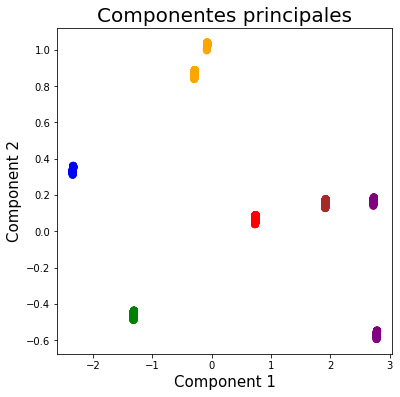

In [ ]:
fig = plt.figure(figsize = (6,6))

ax = fig.add_subplot(1,1,1)
ax.set_xlabel("Component 1", fontsize = 15)
ax.set_ylabel("Component 2", fontsize = 15)
ax.set_title("Componentes principales", fontsize=20)

color_theme = np.array(["blue", "green", "orange", "red", "brown", "purple"])
ax.scatter (x = pca_df_final.Component_1, y=pca_df_final.Component_2,
            c=color_theme[pca_df_final.KMeans_Clusters], s=50)
plt.show()

# Opción B: Modelo de clasificación Binaria


### Dataset Fictício



Un cop tenim les característiques necessaries creem un conjunt de pacients 'idonis' ficticis

In [ ]:
fake_df = pd.DataFrame()

#NORMAL VALUES
fake_df['gender'] = np.random.randint(0,2, size=20000)
fake_df['age'] = np.random.randint(0,91, size=20000)
fake_df['cronic_disease'] = np.random.randint(0,2, size=20000)
fake_df['medication_last15'] = np.random.randint(0,2, size=20000)
fake_df['smoke'] = np.random.randint(0,2, size=20000)

#RESULT VALUES
if camp_1 == 2:
  conditions = [fake_df['age'].ge(camp_2) & fake_df['age'].le(camp_3) & fake_df['cronic_disease'].eq(camp_4) & fake_df['medication_last15'].eq(camp_5) & fake_df['smoke'].eq(camp_6)]
else:
  conditions = [fake_df['age'].ge(camp_2) & fake_df['age'].le(camp_3) & fake_df['cronic_disease'].eq(camp_4) & fake_df['medication_last15'].eq(camp_5) & fake_df['smoke'].eq(camp_6) & fake_df['gender'].eq(camp_1)]
choices = [1]
fake_df['value'] = np.select(conditions, choices, default=0)
fake_df['age'].unique()
# SAVE DATASET
fake_df.to_csv(path+'/fake_data.csv')

### Modelo de Clasificación Binária

Un cop tenim el dataset fictici, creem la red neuronal:

In [ ]:
train = pd.read_csv(path+'/fake_data.csv')

del train['Unnamed: 0']
train.info()

x_data = train.iloc[:, :5].values

y_data = train['value'].values

xtrain, xtest, ytrain, ytest = train_test_split(x_data, y_data, test_size=0.3, shuffle = True)

np.shape(xtrain)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   gender             20000 non-null  int64
 1   age                20000 non-null  int64
 2   cronic_disease     20000 non-null  int64
 3   medication_last15  20000 non-null  int64
 4   smoke              20000 non-null  int64
 5   value              20000 non-null  int64
dtypes: int64(6)
memory usage: 937.6 KB


(14000, 5)

In [ ]:
model = Sequential()

model.add(Dense(4, activation='relu', kernel_initializer='random_normal',input_shape = (5,)))
model.add(Dense(4, activation='relu', kernel_initializer='random_normal'))
model.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

In [ ]:
#sgd = keras.optimizers.SGD(lr=0.5, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(xtrain, ytrain, batch_size=10 ,epochs=10)

Epoch 1/10
1400/1400 [==============================] - 4s 2ms/step - loss: 0.2500 - accuracy: 0.9470
Epoch 2/10
1400/1400 [==============================] - 2s 1ms/step - loss: 0.1342 - accuracy: 0.9477
Epoch 3/10
1400/1400 [==============================] - 2s 1ms/step - loss: 0.0900 - accuracy: 0.9477
Epoch 4/10
1400/1400 [==============================] - 2s 1ms/step - loss: 0.0768 - accuracy: 0.9479
Epoch 5/10
1400/1400 [==============================] - 2s 1ms/step - loss: 0.0659 - accuracy: 0.9629
Epoch 6/10
1400/1400 [==============================] - 2s 1ms/step - loss: 0.0534 - accuracy: 0.9794
Epoch 7/10
1400/1400 [==============================] - 2s 1ms/step - loss: 0.0434 - accuracy: 0.9868
Epoch 8/10
1400/1400 [==============================] - 2s 1ms/step - loss: 0.0351 - accuracy: 0.9908
Epoch 9/10
1400/1400 [==============================] - 3s 2ms/step - loss: 0.0288 - accuracy: 0.9935
Epoch 10/10
1400/1400 [==============================] - 2s 2ms/step - loss: 0.024

In [ ]:
loss_and_metrics = model.evaluate(xtest, ytest)

188/188 [==============================] - 0s 1ms/step - loss: 0.0229 - accuracy: 0.9945


In [ ]:
age = 30
gender = 0
dis = 0
smoke = 0
med = 0
test_input = np.array( [[ gender, age, dis, med, smoke]] )
model.predict(test_input)

array([[0.86395454]], dtype=float32)

Codi per guardar la red neuronal:

In [ ]:
# serializar el modelo a JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serializar los pesos a HDF5
model.save_weights("model.h5")
print("Modelo Guardado!")
 
# mas tarde...
 
# cargar json y crear el modelo
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# cargar pesos al nuevo modelo
loaded_model.load_weights("model.h5")
print("Cargado modelo desde disco.")
 
# Compilar modelo cargado y listo para usar.
loaded_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['binary_accuracy'])

Modelo Guardado!
Cargado modelo desde disco.


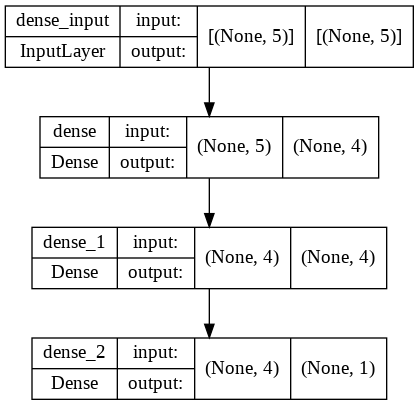

In [ ]:
# Visualizamos modelo
plot_model(model, to_file=path+'/model_plot.png', show_shapes=True, show_layer_names=True)

### Predicción con el dataset real

Hacemos la prediccion con el dataset de pacientes reales y guardamos los modelos

In [ ]:
data = patient_noid.values

result = model.predict(data)


In [ ]:
result_0_1 = np.around(result, decimals=0)
print('CLASIFICACION FINALIZADA')

CLASIFICACION FINALIZADA


In [ ]:
patients['apto'] = result_0_1
patients['real_value'] = result


In [ ]:
patients.to_csv(path+'/results.csv')

# Conclusiones

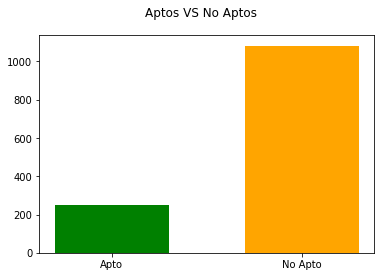

In [ ]:
# Numero de Aptos VS Número de No Aptos
fig = plt.figure()

options=['Apto', 'No Apto']
aptos  = patients[(patients['apto'] == 1)]
values = [len(aptos), len(patients)-len(aptos)]

plt.bar(options, values, 0.6, color=['green', 'orange'])
plt.suptitle('Aptos VS No Aptos')
plt.show()


<BarContainer object of 6 artists>

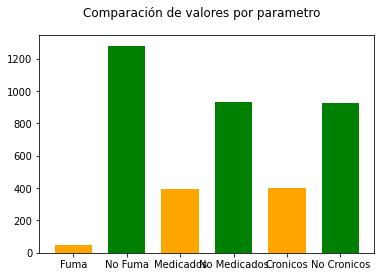

In [ ]:
fig = plt.figure()
options = ['Fuma', 'No Fuma', 'Medicados', 'No Medicados', 'Cronicos', 'No Cronicos']
fumadores = patients[(patients['smoke'] == 1)]
medicados = patients[(patients['medication_last15'] == 1)]
cronicos = patients[(patients['cronic_disease'] == 1)]
values = [len(fumadores), len(patients)-len(fumadores), len(medicados), len(patients)-len(medicados), len(cronicos), len(patients)-len(cronicos)]

plt.suptitle('Comparación de valores por parametro')

plt.bar(options, values, 0.7, color=['orange', 'green'])